In [5]:
import gpytorch
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from gpytorch.kernels import RBFKernel

In [4]:
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://packagecloud.io/github/git-lfs/pypi/simple
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached pandas-2.0.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
  Using cached pytz-2024.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2024.1-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached pandas-2.0.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.4 MB)
Using cached pytz-2024.2-py2.py3-none-any.whl (508 kB)
Using cached tzdata-2024.1-py2.py3-none-any.whl (345 kB)


## GP Class and Setup

In [6]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, dims=1):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = RBFKernel(ard_num_dims=dims)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x) # p(f)

In [7]:
def get_mll(gp, x, y):
    N = len(x)
    covar_matrix = gp.covar_module(x,x).evaluate()
    covar_matrix += gp.likelihood.noise * torch.eye(N).to(x.device)
    log_mll = - 0.5 * (y.T @ torch.inverse(covar_matrix)) @ y 
    log_mll += - 0.5 * torch.logdet(covar_matrix)
    log_mll += - 0.5 * N * np.log(2 * np.pi)

    return log_mll

def get_conditional_mll(gp, x, y, xm, ym):
    return get_mll(gp, x, y) - get_mll(gp, xm, ym)

## Generate Data

In [8]:
dims = 2
n_per_dim = 20
xmax = 2.
ntrain = 5
ls_norm = 3.
noise = 1e-2

x = np.array([0, 0, 1])
edge_x = np.linspace(0, xmax, n_per_dim)
xyz = np.vstack(tuple([x for _ in range(dims)])).T
hist, edges = np.histogramdd(xyz, tuple([edge_x for _ in range(dims)]))
x = np.vstack(np.meshgrid(*edges)).reshape(len(edges), -1).T
x = torch.FloatTensor(x)

lh = gpytorch.likelihoods.GaussianLikelihood()
lh.noise = noise
model = ExactGPModel(None, None, lh, dims)
model.covar_module.lengthscale = torch.tensor([[0.4, 2.]])
model.eval();

In [9]:
torch.manual_seed(11)
y = lh(model(x)).sample()

shuffle = torch.randperm(x.shape[0])
train_x = x[shuffle[:ntrain]]
train_y = y[shuffle[:ntrain]]

test_x = x[shuffle[ntrain:]]
test_y = y[shuffle[ntrain:]]

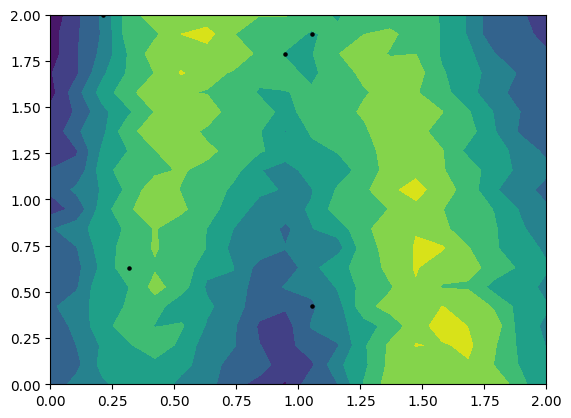

In [10]:
X, Y = np.meshgrid(edge_x, edge_x)
plt.contourf(X, Y, y.reshape(n_per_dim, -1))
plt.scatter(train_x[:, 0], train_x[:, 1], color='k',
           s=5)

In [11]:
lengthscales1 = torch.linspace(0.05, 1, 10)
lengthscales2 = torch.linspace(1., 3., 11)

nshuffle = 10
m = 4

mll_array = torch.zeros(lengthscales1.shape[0],lengthscales2.shape[0])
error_array = torch.zeros(lengthscales1.shape[0],lengthscales2.shape[0])
cmll_array = torch.zeros(lengthscales1.shape[0],lengthscales2.shape[0], nshuffle)

for x0_idx, x0ls in enumerate(lengthscales1):
    for x1_idx, x1ls in enumerate(lengthscales2):
        kernel = RBFKernel(ard_num_dims=dims)
        kernel.lengthscale = torch.tensor([[x0ls.item(), x1ls.item()]])

        ## Compute Error LL  and MLL ##
        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        likelihood.noise_covar.noise = noise
        gp = ExactGPModel(
            train_x=train_x,
            train_y=train_y,
            likelihood=likelihood,
            dims=dims
        ).to(x.device)
        gp.covar_module = kernel

        gp.eval()
        likelihood.eval()
        f_preds = gp(test_x)
        y_preds = likelihood(f_preds)
        error_array[x0_idx, x1_idx] = y_preds.log_prob(test_y).item()
        mll_array[x0_idx, x1_idx] = get_mll(gp, train_x, train_y).item()
    
for s_idx in range(nshuffle):
    order = torch.randperm(train_x.shape[0])
    xm = train_x[order[:m], :]
    xstar = train_x[order[m:], :]
    
    ym = train_y[order[:m]]
    ystar = train_y[order[m:]]
    
    for x0_idx, x0ls in enumerate(lengthscales1):
        for x1_idx, x1ls in enumerate(lengthscales2):
            kernel = RBFKernel(ard_num_dims=dims)
            kernel.lengthscale = torch.tensor([[x0ls.item(), x1ls.item()]])

            ## Compute Error LL  and MLL ##
            likelihood = gpytorch.likelihoods.GaussianLikelihood()
            likelihood.noise_covar.noise = noise
            gp = ExactGPModel(
                train_x=train_x,
                train_y=train_y,
                likelihood=likelihood,
                dims=dims
            ).to(x.device)
            gp.covar_module = kernel
            cmll_array[x0_idx, x1_idx, s_idx] = get_conditional_mll(gp, train_x, train_y, xm, ym).item()

/tmp/ipykernel_450910/2063724067.py:5: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3697.)
  log_mll = - 0.5 * (y.T @ torch.inverse(covar_matrix)) @ y


In [12]:
def rescale(lst):
    lst = np.array(lst)
    return (lst - np.min(lst)) / (np.max(lst - np.min(lst)))


plt_cmll = rescale(cmll_array.mean(-1).detach())
plt_error = rescale(error_array.detach())
plt_mll = rescale(mll_array.detach())

Text(0.5, 1.0, 'CMLL')

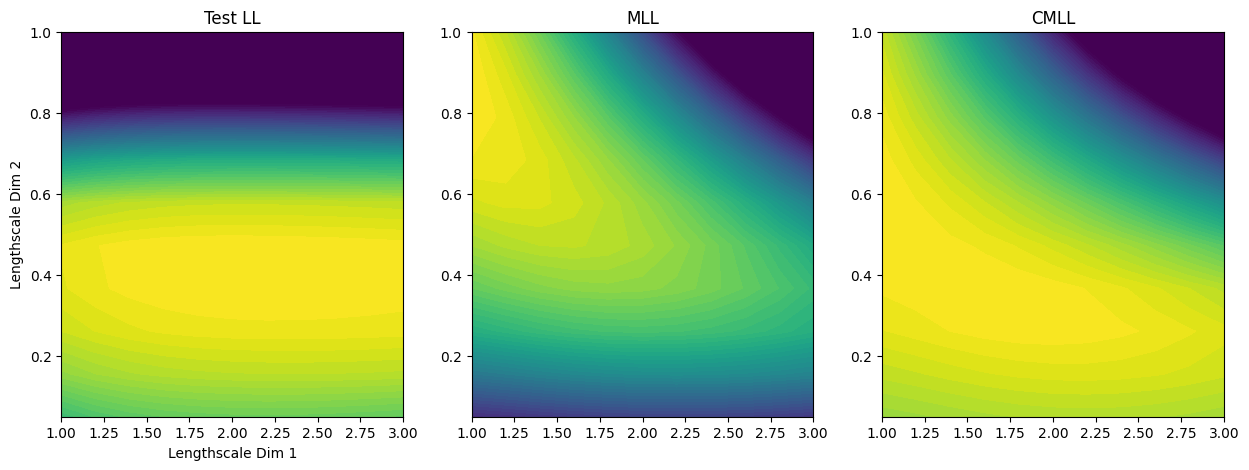

In [13]:
cmap='viridis'
vmin = 0.5
vmax = 1.
levels = 100
X, Y = np.meshgrid(lengthscales2, lengthscales1)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].contourf(X, Y, plt_error, cmap=cmap, vmin=vmin, levels=levels)
ax[0].set_title("Test LL")
ax[0].set_xlabel("Lengthscale Dim 1")
ax[0].set_ylabel("Lengthscale Dim 2")
ax[1].contourf(X, Y, plt_mll, cmap=cmap, vmin=vmin, levels=levels)
ax[1].set_title("MLL")
ax[2].contourf(X, Y, plt_cmll, cmap=cmap, vmin=vmin, levels=levels)
ax[2].set_title("CMLL")

Text(0.5, 1.0, 'Test LL - CMLL')

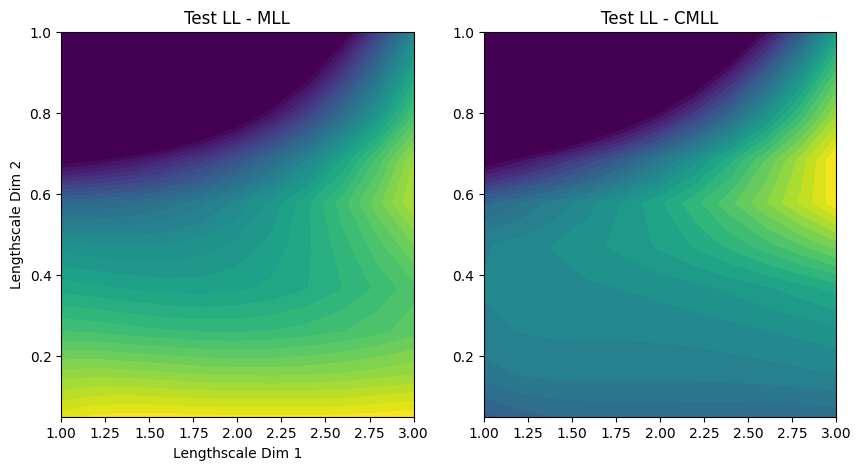

In [14]:
cmap='viridis'
vmin = -0.2
vmax = 0.2
levels = 100
X, Y = np.meshgrid(lengthscales2, lengthscales1)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].contourf(X, Y, plt_error-plt_mll, cmap=cmap, vmin=vmin, levels=levels)
ax[0].set_title("Test LL - MLL")
ax[0].set_xlabel("Lengthscale Dim 1")
ax[0].set_ylabel("Lengthscale Dim 2")
ax[1].contourf(X, Y, plt_error-plt_cmll, cmap=cmap, vmin=vmin, levels=levels)
ax[1].set_title("Test LL - CMLL")

## Higher Dim

In [15]:
torch.manual_seed(33)
dims = 20
xmax = 2.
ntrain = 5
m = 4
ntest = 50
ls_max = 5.
noise = 1e-2

lengthscales = torch.rand(dims).unsqueeze(0) * ls_max
lengthscales[0][0] = 1.
lengthscales[0][1] = 2.
x = torch.rand(ntrain + ntest, dims) * xmax


lh = gpytorch.likelihoods.GaussianLikelihood()
lh.noise = noise
model = ExactGPModel(None, None, lh, dims)
model.covar_module.lengthscale = lengthscales
model.eval();

In [16]:
lengthscales

tensor([[1.0000, 2.0000, 0.9685, 1.6799, 1.0042, 3.4849, 3.1836, 0.7258, 4.1065,
         1.1823, 1.8511, 4.5842, 0.1666, 3.5913, 0.1626, 1.1602, 0.9770, 4.2678,
         2.8328, 1.2571]])

In [17]:
torch.manual_seed(11)
y = lh(model(x)).sample()

shuffle = torch.randperm(x.shape[0])
train_x = x[shuffle[:ntrain]]
train_y = y[shuffle[:ntrain]]

test_x = x[shuffle[ntrain:]]
test_y = y[shuffle[ntrain:]]

In [18]:
y.reshape(x.shape[0], -1).shape

torch.Size([55, 1])

In [19]:
lengthscales

tensor([[1.0000, 2.0000, 0.9685, 1.6799, 1.0042, 3.4849, 3.1836, 0.7258, 4.1065,
         1.1823, 1.8511, 4.5842, 0.1666, 3.5913, 0.1626, 1.1602, 0.9770, 4.2678,
         2.8328, 1.2571]])

In [20]:
ls0 = torch.linspace(0.5, 3., 15)
ls1 = torch.linspace(0.5, 4., 16)
test_ls = lengthscales.clone()
nshuffle = 10

mll_array = torch.zeros(ls0.shape[0],ls1.shape[0])
error_array = torch.zeros(ls0.shape[0],ls1.shape[0])
cmll_array = torch.zeros(ls0.shape[0],ls1.shape[0], nshuffle)

for x0_idx, x0ls in enumerate(ls0):
    for x1_idx, x1ls in enumerate(ls1):
        kernel = RBFKernel(ard_num_dims=dims)
        test_ls[0][0] = x0ls
        test_ls[0][1] = x1ls
        kernel.lengthscale = test_ls

        ## Compute Error LL  and MLL ##
        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        likelihood.noise_covar.noise = noise
        gp = ExactGPModel(
            train_x=train_x,
            train_y=train_y,
            likelihood=likelihood,
            dims=dims
        ).to(x.device)
        gp.covar_module = kernel

        gp.eval()
        likelihood.eval()
        f_preds = gp(test_x)
        y_preds = likelihood(f_preds)
        error_array[x0_idx, x1_idx] = y_preds.log_prob(test_y).item()
        mll_array[x0_idx, x1_idx] = get_mll(gp, train_x, train_y).item()
    
for s_idx in range(nshuffle):
    order = torch.randperm(train_x.shape[0])
    xm = train_x[order[:m], :]
    xstar = train_x[order[m:], :]
    
    ym = train_y[order[:m]]
    ystar = train_y[order[m:]]
    
    for x0_idx, x0ls in enumerate(ls0):
        for x1_idx, x1ls in enumerate(ls1):
            kernel = RBFKernel(ard_num_dims=dims)
            test_ls[0][0] = x0ls
            test_ls[0][1] = x1ls
            kernel.lengthscale = test_ls

            ## Compute Error LL  and MLL ##
            likelihood = gpytorch.likelihoods.GaussianLikelihood()
            likelihood.noise_covar.noise = noise
            gp = ExactGPModel(
                train_x=train_x,
                train_y=train_y,
                likelihood=likelihood,
                dims=dims
            ).to(x.device)
            gp.covar_module = kernel
            cmll_array[x0_idx, x1_idx, s_idx] = get_conditional_mll(gp, train_x, train_y, xm, ym).item()

In [21]:
def rescale(lst):
    lst = np.array(lst)
    return (lst - np.min(lst)) / (np.max(lst - np.min(lst)))


plt_cmll = rescale(cmll_array.mean(-1).detach())
plt_error = rescale(error_array.detach())
plt_mll = rescale(mll_array.detach())

Text(0.5, 1.0, 'CMLL')

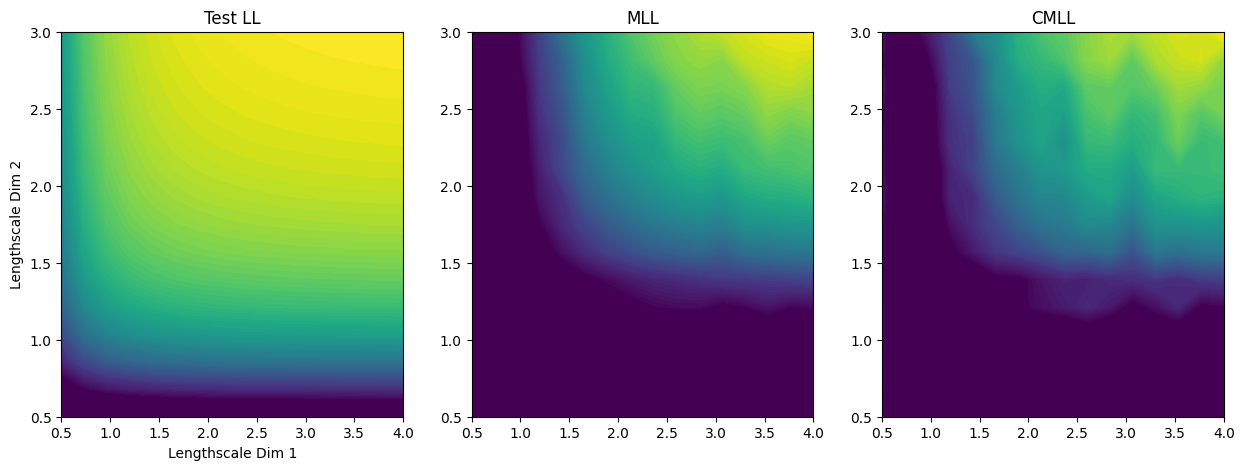

In [22]:
cmap='viridis'
vmin = 0.25
vmax = 1.
levels = 100
X, Y = np.meshgrid(ls1, ls0)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].contourf(X, Y, plt_error, cmap=cmap, vmin=vmin, levels=levels)
ax[0].set_title("Test LL")
ax[0].set_xlabel("Lengthscale Dim 1")
ax[0].set_ylabel("Lengthscale Dim 2")
ax[1].contourf(X, Y, plt_mll, cmap=cmap, vmin=vmin, levels=levels)
ax[1].set_title("MLL")
ax[2].contourf(X, Y, plt_cmll, cmap=cmap, vmin=vmin, levels=levels)
ax[2].set_title("CMLL")

Text(0.5, 1.0, 'Test LL - CMLL')

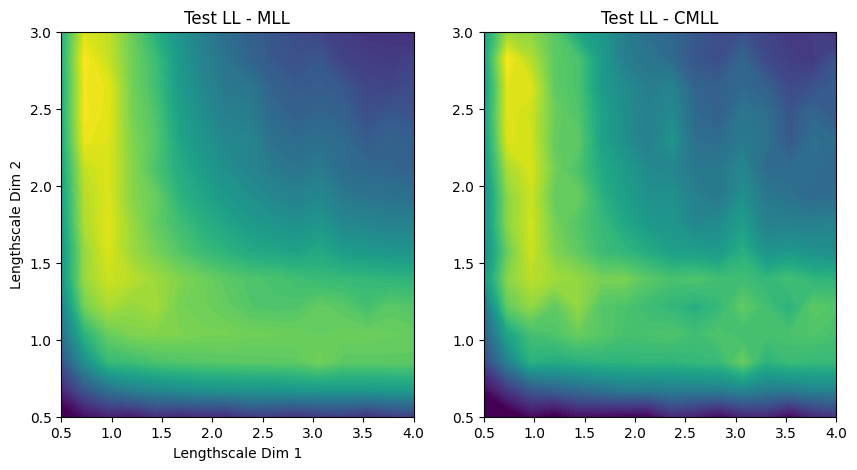

In [23]:
cmap='viridis'
vmin = -0.1
vmax = 0.1
levels = 100
X, Y = np.meshgrid(ls1, ls0)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].contourf(X, Y, plt_error-plt_mll, cmap=cmap, vmin=vmin, levels=levels)
ax[0].set_title("Test LL - MLL")
ax[0].set_xlabel("Lengthscale Dim 1")
ax[0].set_ylabel("Lengthscale Dim 2")
ax[1].contourf(X, Y, plt_error-plt_cmll, cmap=cmap, vmin=vmin, levels=levels)
ax[1].set_title("Test LL - CMLL")